In [1]:
import warnings
warnings.filterwarnings('ignore')

# Underthesea - A Vietnamese NLP toolkit
# !pip install underthesea > /dev/null 2>&1 # not print the pip installation
# from underthesea import word_tokenize
# from underthesea import text_normalize

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch
import wordcloud
import regex as re
import string
import nltk
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score,confusion_matrix
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel,RobertaForSequenceClassification,get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

2025-05-10 13:23:18.997819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746883399.199580      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746883399.258014      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_data(path):
    df = pd.read_csv(path, sep='\t')
    return df

df_train = get_data('/kaggle/input/sentiment/dataset-train-final.tsv')
df_test = get_data('/kaggle/input/sentiment/dataset-test-final.tsv')
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [3]:
LABEL_MAP = {
    'Negative': 0, 'Neutral': 1, 'Positive': 2
}

In [4]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF" 
                u"\U0001F680-\U0001F6FF"  
                u"\U0001F1E0-\U0001F1FF"  
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis. 

def clean_text(text):
    text = text.lower() # lowercase text
    
    text = re.sub(emoji_pattern, " ", text) # remove emojis
    
    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')
    
    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation
    
    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]
        
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation
        
    text = re.sub(r"\s+", " ", text) # reduce multiple spaces
    
    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)
    
    '''
    Proper tokenization allows models or algorithms to understand the semantics of the text better. 
    For instance, `"đi chơi" (go play)` should be treated as one unit 
    instead of two separate words "đi" (go) and "chơi" (play) for proper semantic understanding.
    '''
    return text

Number of words: 37762
Most common words: [('chưa ôn_tập được nhiều kiến_thức cơ_bản của anh văn 1', 1), ('rất god vị_trí trung_tâm sạch_sẽ nhân_viên nhiệt_tình', 1), ('thầy rất nhiệt_tình hướng_dẫn thực_hành kỹ_càng', 1), ('thầy tâm_huyết vui_vẻ nhiệt_tình giải_đáp thắc_mắc của sinh_viên', 1), ('có giảng lại lý_thuyết cặn_kẽ', 1), ('mẹ em dùng i phone 6', 1), ('sao mình thấy như đọc ấy chứ không rap', 1), ('đang xài 6 nhưng vẫn thích mẩu se cầm vừa tay nhìn sang chỉ tiếc là nó y_hệt ip 5 s ai thấy đúng like em phát', 1), ('thầy không sửa bài_tập trên lớp thầy chỉ giảng lý_thuyết theo em như thế là ít có hiệu_quả', 1), ('tăng_cường thời_lượng giải bài_tập', 1), ('bát này là cũng khá no đấy hơi ít cá và nấm so với mình nghĩ hương_vị cũng ok_quan này còn mấy vị cháo nữa mà chưa có dịp ghé lại căn_bản vì xa chỗ mình', 1), ('giảng_viên nhiệt_tình lên lớp rất đúng giờ', 1), ('áo chất vải mịn in tốt hơi mỏng nhưng so với giá tiền vậy thì cũng ok cỡ nhỏ hơn so với kích_thước cửa_hàng ghi', 1)

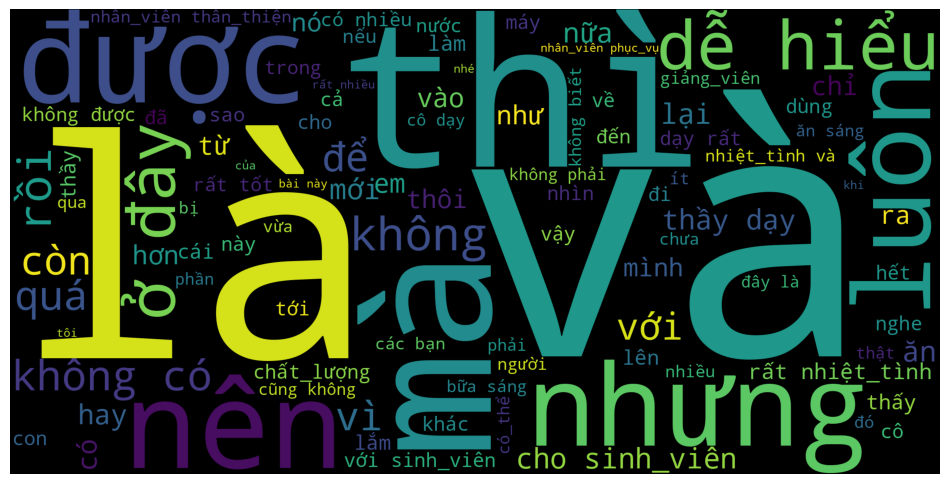

In [5]:
# Create bag-of-words
all_words = [token for token in df['corpus'].tolist() if token and token != '']

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# Print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

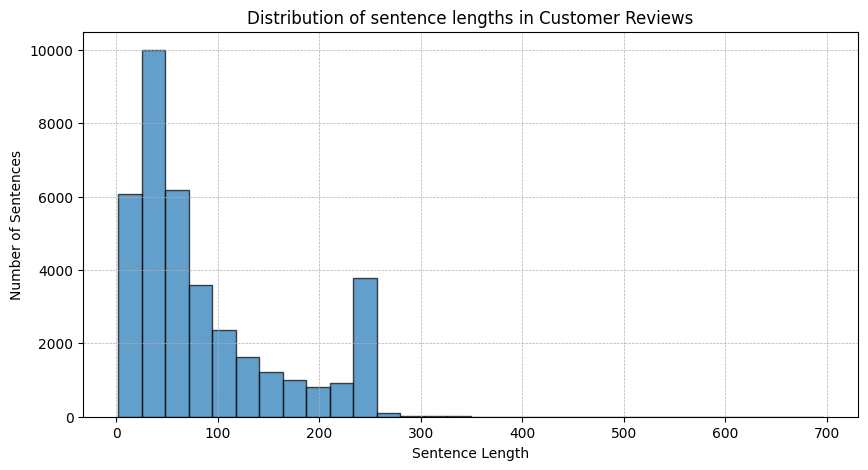

In [6]:
lengths = df['corpus'].apply(len)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of sentence lengths in Customer Reviews')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

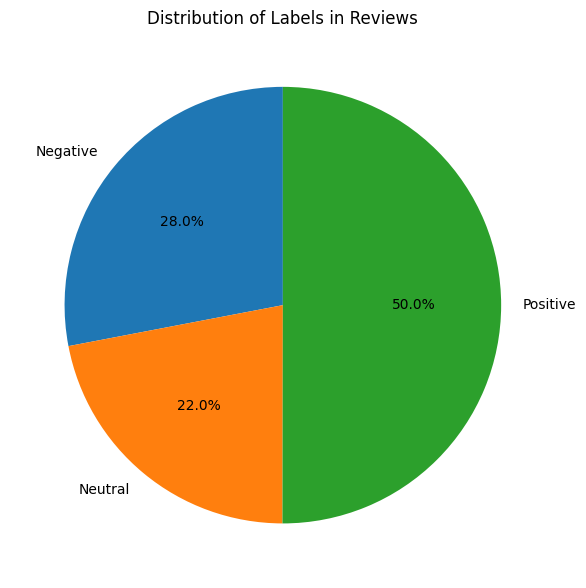

In [7]:
# Count the occurrences of each label and topic
label_counts = df['label'].value_counts().sort_index()
# Thiết lập figure
fig, ax = plt.subplots(figsize=(6, 6))  # Chỉ cần 1 subplot, kích thước nhỏ hơn

# Biểu đồ tròn cho labels
labels = ['Negative', 'Neutral', 'Positive']  # Các nhãn đã cập nhật
ax.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Labels in Reviews')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [8]:
# train_sentences, test_sentences, train_labels, test_labels = train_test_split(
#     df['corpus'], 
#     df['label'], 
#     test_size=0.1,
#     random_state=42
# )
train_sentences = df_train['corpus']
train_labels = df_train['label']
test_sentences = df_test['corpus']
test_labels = df_test['label']
print(len(train_sentences),len(train_labels))
print(len(test_sentences),len(test_labels))

33985 33985
3777 3777


In [9]:
from sklearn.utils import resample

# Separate neutral comments
neutral_indices = np.where(train_labels == 1)[0]
oversample_size = len(train_labels[train_labels == 0]) - len(neutral_indices)

# Over-sample the neutral comments
oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

# Combine the original sentences and labels with the oversampled data
oversampled_neutral_sentences = np.array(train_sentences)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([train_sentences, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1] * oversample_size)], axis=0)


In [10]:
oversampled_neutral_sentences = np.array(train_sentences)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([train_sentences, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = pd.Series(train_labels_oversampled)

In [11]:
# Count occurrences of each label in train_labels_oversampled
unique_labels, counts = np.unique(train_labels_oversampled, return_counts=True)

# Display the distribution
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 9518
Label 1: 9518
Label 2: 17002


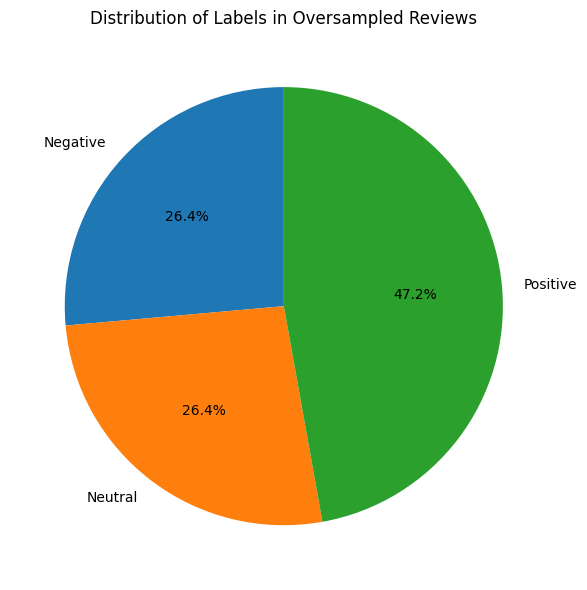

In [12]:
# First, you need to create a new DataFrame or series for your oversampled data
# For this example, let's assume your oversampled DataFrame is `df_oversampled`

# Update the label counts based on the oversampled data
label_counts_oversampled = pd.Series(train_labels_oversampled).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))

# Pie chart for labels after over-sampling
labels = ['Negative', 'Neutral', 'Positive']  
ax.pie(label_counts_oversampled, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Labels in Oversampled Reviews')

plt.tight_layout()
plt.show()

In [13]:

train_sents, val_sents, train_labels, val_labels = train_test_split(
    train_sentences_oversampled, 
    train_labels_oversampled, 
    test_size=0.1,  # 10% of the data will be used for validation
    random_state=42
)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)
print(f"Number of GPUs available: {torch.cuda.device_count()}")  # In số lượng GPU
print(f"cuda=: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    BATCH_SIZE = 32
    print('BATCH_SIZE',BATCH_SIZE)

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Number of GPUs available: 2
cuda=: True
BATCH_SIZE 32


In [15]:
MAX_LEN = 250

def convert_sents_ids(sents):
    ids = []
    batch_mask = []
    for sent in sents:
        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = tokenizer.encode_plus(
            sent,
            truncation=True,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )
        ids.append(encoding['input_ids'].flatten())
        batch_mask.append(encoding['attention_mask'].flatten())
    return torch.stack(ids), torch.stack(batch_mask)

test_text = test_sentences
train_ids , train_masks = convert_sents_ids(train_sents)
val_ids, val_masks  = convert_sents_ids(val_sents)
test_ids, test_masks  = convert_sents_ids(test_text)

In [16]:
def make_data_loader(ids, masks, labels): 
    data = TensorDataset(ids, masks, labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=BATCH_SIZE)
    return dataloader

train_labels = torch.tensor(train_labels.values)
val_labels = torch.tensor(val_labels.values)
test_labels = torch.tensor(test_labels.values)

train_dataloader = make_data_loader(train_ids, train_masks, train_labels)
val_dataloader = make_data_loader(val_ids, val_masks, val_labels)
test_dataloader = make_data_loader(test_ids, test_masks, test_labels)

In [17]:
# Định nghĩa hàm tính toán độ chính xác và các chỉ số đánh giá khác
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()  # Chọn lớp có xác suất cao nhất
    labels_flat = labels.flatten()   # Làm phẳng danh sách nhãn
    
    # Tính toán các chỉ số đánh giá
    accuracy = accuracy_score(pred_flat, labels_flat)
    f1 = f1_score(pred_flat, labels_flat, average='weighted')
    precision = precision_score(pred_flat, labels_flat, average='weighted')
    recall = recall_score(pred_flat, labels_flat, average='weighted')

    return accuracy, f1, precision, recall

In [18]:
def plot_training_metrics(train_losses, train_accs, val_losses, val_accs, epochs):
    # Tạo figure với 2 subplot (Loss và Accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Biểu đồ Loss
    ax1.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    ax1.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Biểu đồ Accuracy
    ax2.plot(range(1, epochs + 1), train_accs, label='Train Acc', marker='o')
    ax2.plot(range(1, epochs + 1), val_accs, label='Val Acc', marker='o')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Điều chỉnh layout và hiển thị
    plt.tight_layout()
    plt.show()

In [19]:
# 4. Định nghĩa hàm train
def train(model, train_dataloader, val_dataloader, optimizer,scheduler, epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience = 2 
    patience_counter = 0

    # Danh sách để lưu trữ các metric qua từng epoch
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        total_train_f1 = 0
        
        # Training loop
        for batch in tqdm(train_dataloader):
            input_ids, masks, labels = [t.to(device) for t in batch]
            
            optimizer.zero_grad()
            logits = model(input_ids, masks)
            loss = loss_fn(logits, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            # Tính metrics
            acc, f1, precision, recall = flat_accuracy(logits.detach().cpu().numpy(), labels.cpu().numpy())
            total_train_loss += loss.item()
            total_train_acc += acc
            total_train_f1 += f1
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        total_val_f1 = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids, masks, labels = [t.to(device) for t in batch]
                logits = model(input_ids, masks)
                loss = loss_fn(logits, labels)
                
                acc, f1, precision, recall = flat_accuracy(logits.cpu().numpy(), labels.cpu().numpy())
                total_val_loss += loss.item()
                total_val_acc += acc
                total_val_f1 += f1
        
        # Tính trung bình các metrics
        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_acc = total_train_acc / len(train_dataloader)
        avg_train_f1 = total_train_f1 / len(train_dataloader)
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_acc = total_val_acc / len(val_dataloader)
        avg_val_f1 = total_val_f1 / len(val_dataloader)

        # Lưu các metric vào danh sách
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        
        # In kết quả
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | Train F1: {avg_train_f1:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f} | Val F1: {avg_val_f1:.4f}")
        print("-"*20)
        
        if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                    
    # Vẽ biểu đồ sau khi huấn luyện xong
    plot_training_metrics(train_losses, train_accs, val_losses, val_accs, epochs)
    return model

In [20]:
# 5. Hàm đánh giá
def evaluate(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, masks, labels = [t.to(device) for t in batch]
            logits = model(input_ids, masks)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
    print(classification_report(y_true, y_pred, target_names=list(LABEL_MAP.keys()), digits=4))

    # Tính ma trận nhầm lẫn
    # cm = confusion_matrix(y_true, y_pred)
    # print("\nConfusion Matrix:")
    # print(cm)
    
    # # Vẽ biểu đồ ma trận nhầm lẫn
    # plt.figure(figsize=(8, 6))
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title('Confusion Matrix')
    # plt.colorbar()
    
    # # Thêm nhãn cho trục
    # classes = list(LABEL_MAP.keys())
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    
    # # Thêm giá trị vào từng ô
    # thresh = cm.max() / 2.
    # for i, j in np.ndindex(cm.shape):
    #     plt.text(j, i, format(cm[i, j], 'd'),
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")
    
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.tight_layout()
    # plt.show()

In [21]:

class CustomPhoBERT(nn.Module):
    def __init__(self, model_name, num_labels, layers_to_use=[6, 9, 10, 11], dropout_prob=0.4):
        super().__init__()
        self.num_labels = num_labels
        self.layers_to_use = layers_to_use
        self.phobert = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        self.hidden_size = self.phobert.config.hidden_size
        self.dropout = nn.Dropout(dropout_prob)

        for name, param in self.phobert.named_parameters():
            # Kiểm tra nếu tham số thuộc các layer transformer
            if "layer" in name:
                # Lấy số thứ tự layer
                layer_num = int(name.split("layer.")[1].split(".")[0])
                # Đóng băng nếu layer không nằm trong layers_to_use
                if layer_num not in self.layers_to_use:
                    param.requires_grad = False
                    
        
        self.classifier = nn.Sequential(
            nn.Linear(len(layers_to_use) * self.hidden_size, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, num_labels)
        )

        
    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        
        # Lấy các lớp đích và trích [CLS] token
        cls_embeddings = []
        for layer in self.layers_to_use:
            cls_embeddings.append(hidden_states[layer][:, 0, :])  # [CLS] ở vị trí 0
            
        # Ghép các embeddings
        concatenated = torch.cat(cls_embeddings, dim=1)
        concatenated = self.dropout(concatenated)
        
        # Đưa qua MLP
        logits = self.classifier(concatenated)
        return logits

In [22]:
def train_four_layers():
    PHO_BERT = CustomPhoBERT("vinai/phobert-base-v2", num_labels=len(LABEL_MAP))
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        PHO_BERT = nn.DataParallel(PHO_BERT)
    PHO_BERT = PHO_BERT.to(device)
    
    # 6. Chạy training
    EPOCHS = 5
    
    param_optimizer = list(PHO_BERT.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    
    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
    num_warmup_steps = int(0.1 * len(train_dataloader) * EPOCHS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, 
                                                num_training_steps=len(train_dataloader) * EPOCHS)
    
    trained_model = train(PHO_BERT, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS)
    
    # 7. Đánh giá trên test set
    print("\nTest set evaluation 4:")
    evaluate(trained_model, test_dataloader)
    
    state_dict = trained_model.module.state_dict() if isinstance(trained_model, nn.DataParallel) else trained_model.state_dict()
    torch.save(state_dict, '/kaggle/working/phobert_4_layer.pth')

In [23]:
def train_three_layers():
    PHO_BERT = CustomPhoBERT("vinai/phobert-base-v2", num_labels=len(LABEL_MAP), layers_to_use=[9, 10, 11])
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        PHO_BERT = nn.DataParallel(PHO_BERT)
    PHO_BERT = PHO_BERT.to(device)
    
    # 6. Chạy training
    EPOCHS = 5
    
    param_optimizer = list(PHO_BERT.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    
    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
    num_warmup_steps = int(0.1 * len(train_dataloader) * EPOCHS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, 
                                                num_training_steps=len(train_dataloader) * EPOCHS)
    
    trained_model = train(PHO_BERT, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS)
    
    # 7. Đánh giá trên test set
    print("\nTest set evaluation 3:")
    evaluate(trained_model, test_dataloader)
    
    state_dict = trained_model.module.state_dict() if isinstance(trained_model, nn.DataParallel) else trained_model.state_dict()
    torch.save(state_dict, '/kaggle/working/phobert_3_layer.pth')

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs!


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 0.7357 | Train Acc: 0.6567 | Train F1: 0.6759
Val Loss: 0.3951 | Val Acc: 0.8605 | Val F1: 0.8602
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 2/5
Train Loss: 0.3616 | Train Acc: 0.8641 | Train F1: 0.8642
Val Loss: 0.3542 | Val Acc: 0.8769 | Val F1: 0.8775
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 3/5
Train Loss: 0.3101 | Train Acc: 0.8861 | Train F1: 0.8863
Val Loss: 0.3417 | Val Acc: 0.8816 | Val F1: 0.8819
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 4/5
Train Loss: 0.2777 | Train Acc: 0.9007 | Train F1: 0.9007
Val Loss: 0.3365 | Val Acc: 0.8857 | Val F1: 0.8863
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 5/5
Train Loss: 0.2608 | Train Acc: 0.9056 | Train F1: 0.9056
Val Loss: 0.3436 | Val Acc: 0.8852 | Val F1: 0.8858
--------------------


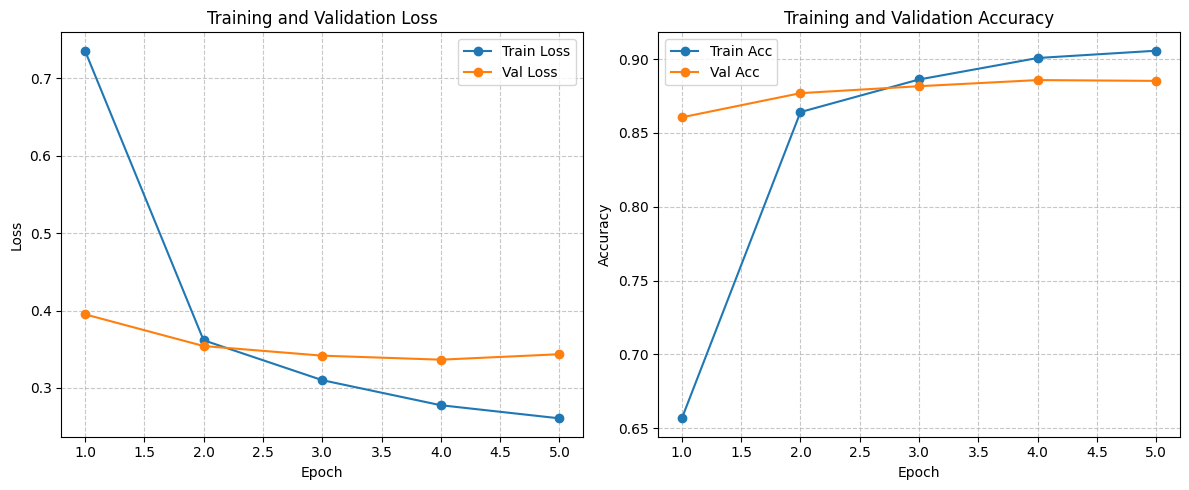


Test set evaluation 4:
              precision    recall  f1-score   support

    Negative     0.8919    0.8970    0.8944      1058
     Neutral     0.8313    0.8022    0.8165       829
    Positive     0.9258    0.9370    0.9314      1890

    accuracy                         0.8962      3777
   macro avg     0.8830    0.8787    0.8808      3777
weighted avg     0.8955    0.8962    0.8958      3777



In [24]:
train_four_layers()

In [25]:
print('----'*25)

----------------------------------------------------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs!


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 0.8318 | Train Acc: 0.5962 | Train F1: 0.6235
Val Loss: 0.4340 | Val Acc: 0.8445 | Val F1: 0.8448
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 2/5
Train Loss: 0.3953 | Train Acc: 0.8517 | Train F1: 0.8518
Val Loss: 0.3667 | Val Acc: 0.8718 | Val F1: 0.8726
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 3/5
Train Loss: 0.3380 | Train Acc: 0.8756 | Train F1: 0.8757
Val Loss: 0.3573 | Val Acc: 0.8785 | Val F1: 0.8796
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 4/5
Train Loss: 0.3095 | Train Acc: 0.8866 | Train F1: 0.8866
Val Loss: 0.3553 | Val Acc: 0.8796 | Val F1: 0.8811
--------------------


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch 5/5
Train Loss: 0.2966 | Train Acc: 0.8918 | Train F1: 0.8919
Val Loss: 0.3533 | Val Acc: 0.8819 | Val F1: 0.8832
--------------------


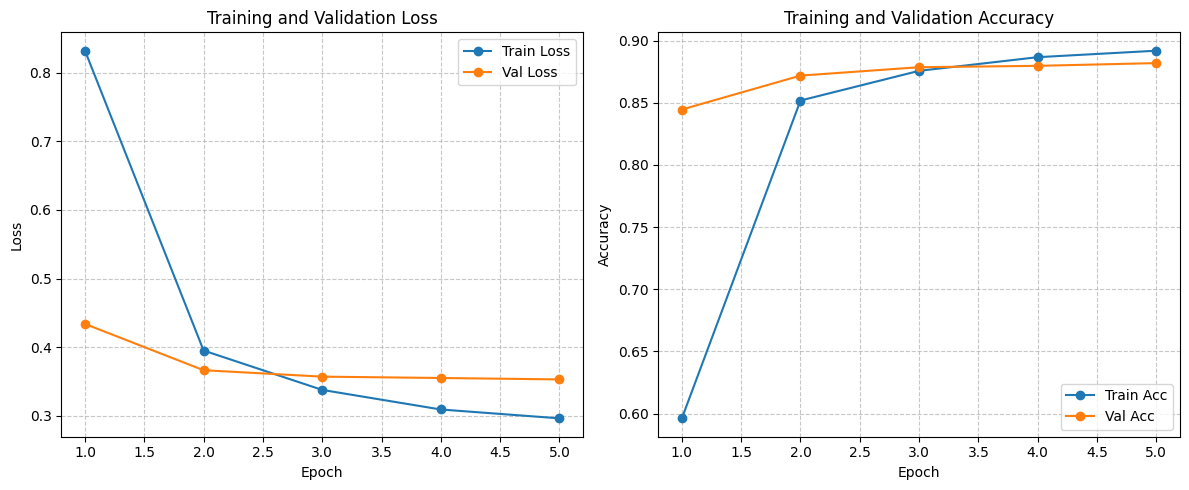


Test set evaluation 3:
              precision    recall  f1-score   support

    Negative     0.8881    0.8998    0.8939      1058
     Neutral     0.8299    0.7768    0.8025       829
    Positive     0.9207    0.9397    0.9301      1890

    accuracy                         0.8928      3777
   macro avg     0.8795    0.8721    0.8755      3777
weighted avg     0.8916    0.8928    0.8919      3777



In [26]:
train_three_layers()